In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Create the data

In [2]:
N = 1000
data = np.random.randint(low=-10, high=10, size=(N, 2))
dataT = torch.tensor(data, dtype=torch.float32)
labels = dataT.sum(axis=1)

In [3]:
dataT[:10], labels[:10]

(tensor([[ -8.,  -8.],
         [  2.,  -1.],
         [  9.,   7.],
         [  7., -10.],
         [ -3., -10.],
         [  5.,   7.],
         [ -5.,  -7.],
         [  5., -10.],
         [ -7.,   7.],
         [ -2.,   0.]]),
 tensor([-16.,   1.,  16.,  -3., -13.,  12., -12.,  -5.,   0.,  -2.]))

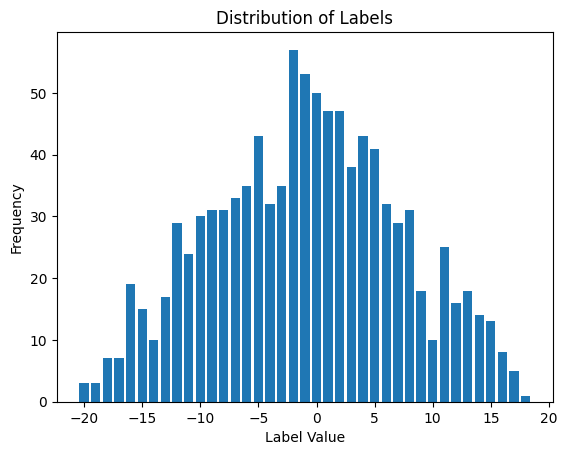

In [4]:
unique_labels, counts = np.unique(labels, return_counts=True)
plt.bar(unique_labels, counts)
plt.xlabel('Label Value')
plt.ylabel('Frequency')
plt.title('Distribution of Labels')
plt.show()

In [5]:
#Split the model into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(dataT, labels, test_size=0.2, random_state=42)

In [6]:
# Convert the train and test dataets into TensorDatasets
data_train = TensorDataset(X_train, y_train)
data_test = TensorDataset(X_test, y_test)

# Convert the train and test datasets into DataLoaders
train_loader = DataLoader(data_train, batch_size=32, shuffle=True, drop_last=True)
test_loader = DataLoader(data_test, batch_size=data_test.tensors[0].shape[0])

# Create the model

In [7]:
class FFNmodel(nn.Module):
    def __init__(self):
        super(FFNmodel, self).__init__()

        self.layer1 = nn.Linear(2, 32)
        self.layer2 = nn.Linear(32, 1)
        self.output = nn.Linear(1, 1)

    def forward(self, x):
      #activation function for layer1
      x = F.relu(self.layer1(x))

      #activation function for layers2
      x = F.relu(self.layer2(x))

      return self.output(x)

In [8]:
# Function to create the model
def create_model():
    model = FFNmodel()

    #Loss funcrion
    loss_fn = nn.MSELoss()

    #Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    return model, loss_fn, optimizer

In [9]:
model = FFNmodel()

for p in model.named_parameters():
  print(p[0])
  print(p[1])

layer1.weight
Parameter containing:
tensor([[-0.5189, -0.5780],
        [ 0.1721, -0.5420],
        [-0.3143,  0.5141],
        [ 0.6753, -0.1855],
        [-0.5799, -0.3792],
        [-0.4339,  0.2350],
        [ 0.1137, -0.3906],
        [-0.5424,  0.2782],
        [ 0.3501,  0.0519],
        [-0.0413,  0.0448],
        [ 0.3571, -0.0142],
        [-0.0905, -0.5407],
        [ 0.1871,  0.3527],
        [-0.4124,  0.2153],
        [ 0.3198, -0.0249],
        [-0.2486,  0.6597],
        [-0.5438,  0.6784],
        [ 0.5430,  0.2929],
        [-0.4656,  0.1420],
        [-0.1577, -0.1362],
        [-0.5538, -0.4855],
        [-0.1878, -0.5507],
        [-0.4936, -0.2931],
        [ 0.2773,  0.3403],
        [-0.0851,  0.6455],
        [ 0.1887, -0.1437],
        [ 0.0725, -0.6279],
        [ 0.2698, -0.6293],
        [-0.6472,  0.4895],
        [-0.6003,  0.1131],
        [-0.3635, -0.0381],
        [-0.7067, -0.0468]], requires_grad=True)
layer1.bias
Parameter containing:
tensor([-0.55

In [25]:
for name, module in model.named_modules():
    print(f"Layer Name: {name}, Layer Type: {type(module)}")

limodel.named_modules()[0]

Layer Name: , Layer Type: <class '__main__.FFNmodel'>
Layer Name: layer1, Layer Type: <class 'torch.nn.modules.linear.Linear'>
Layer Name: layer2, Layer Type: <class 'torch.nn.modules.linear.Linear'>
Layer Name: output, Layer Type: <class 'torch.nn.modules.linear.Linear'>


TypeError: 'generator' object is not subscriptable

In [12]:
list(model.named_children())

[('layer1', Linear(in_features=2, out_features=32, bias=True)),
 ('layer2', Linear(in_features=32, out_features=1, bias=True)),
 ('output', Linear(in_features=1, out_features=1, bias=True))]

# Train the model

In [ ]:
def train_model(nEpochs = 500):
  model, loss_fn, optimizer = create_model()

  #initialize arrays to measure performance
  loss_array = torch.zeros(nEpochs)
  trainAcc = []
  testAcc = []

  for epochi in range(nEpochs):

    #initialize performance parameters for each batch
    batchAcc = []
    batchloss = []

    #Loop for each batch
    for X, y in train_loader:
      yHat = model(X)
      loss = loss_fn(yHat, y.unsqueeze(1)) # Fix: unsqueeze y to match yHat shape

      # initialize graidents for backprop
      optimizer.zero_grad()

      # Calculate loss gradients over the inputs
      loss.backward()

      # Optimize weights
      optimizer.step()

      # Capture loss from the current batch
      batchloss.append(loss.item())

      # Calculate accuracy from the current batch
      matches = torch.abs(yHat - y.unsqueeze(1)) < 1 # Fix: unsqueeze y to match yHat shape
      # matches = torch.argmax(yHat,axis=1) == y
      matchesNumeric = matches.float()
      accuracyPct = 100 * torch.mean(matchesNumeric)
      batchAcc.append(accuracyPct)

    #end of batch loop

    # Add the batch accuracy to trainAcc
    trainAcc.append(torch.mean(torch.tensor(batchAcc)))

    # Add the batch loss to loss_array
    loss_array[epochi] = torch.mean(torch.tensor(batchloss))

    # Run the test for each epoch and calculate the accuracy
    X, y = next(iter(test_loader))
    with torch.no_grad():
      yHat = model(X)

    matches = torch.abs(yHat - y.unsqueeze(1)) < 1 # Fix: unsqueeze y to match yHat shape
    matchesNumeric = matches.float()
    testAcc.append(100 * torch.mean(matchesNumeric))

  return model, loss_array, trainAcc, testAcc

# Run the model

In [ ]:
model, loss_array, trainAcc, testAcc = train_model(nEpochs=1000)

In [ ]:
trainAcc[-1], testAcc[-1]

(tensor(100.), tensor(100.))

# Visualize the results

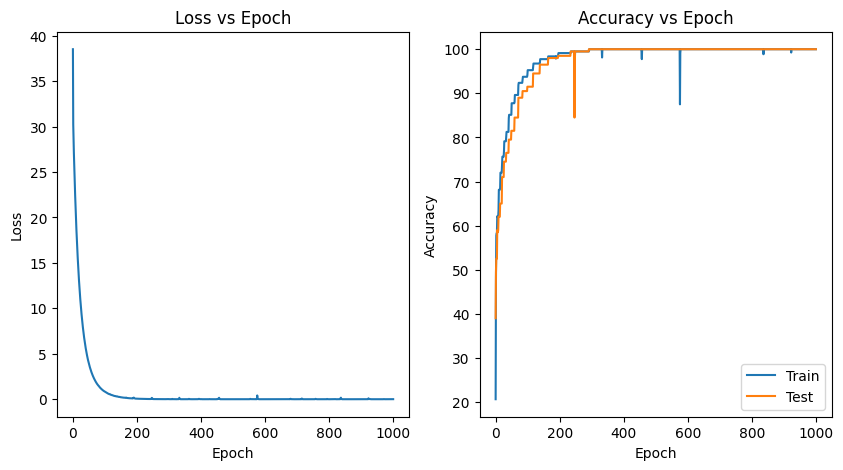

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

ax[0].plot(loss_array)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss vs Epoch')

ax[1].plot(trainAcc, label='Train')
ax[1].plot(testAcc, label='Test')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
ax[1].set_title('Accuracy vs Epoch')

plt.show();

# Evaluate the model

In [ ]:
# Predictions from training data
yHat_train = model(train_loader.dataset.tensors[0])

# Predictions from test data
yHat_test = model(test_loader.dataset.tensors[0])

In [ ]:
# # Calculate accuracy
# accuracy_score(train_loader.dataset.tensors[1], yHat_train.detach().numpy())
# accuracy_score(test_loader.dataset.tensors[1], yHaT_test.detach().numpy())

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate regression metrics
train_mse = mean_squared_error(train_loader.dataset.tensors[1], yHat_train.detach().numpy())
test_mse = mean_squared_error(test_loader.dataset.tensors[1], yHat_test.detach().numpy())

train_mae = mean_absolute_error(train_loader.dataset.tensors[1], yHat_train.detach().numpy())
test_mae = mean_absolute_error(test_loader.dataset.tensors[1], yHat_test.detach().numpy())

print(f'Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}')
print(f'Train MAE: {train_mae:.4f}, Test MAE: {test_mae:.4f}')

Train MSE: 0.0044, Test MSE: 0.0044
Train MAE: 0.0568, Test MAE: 0.0566


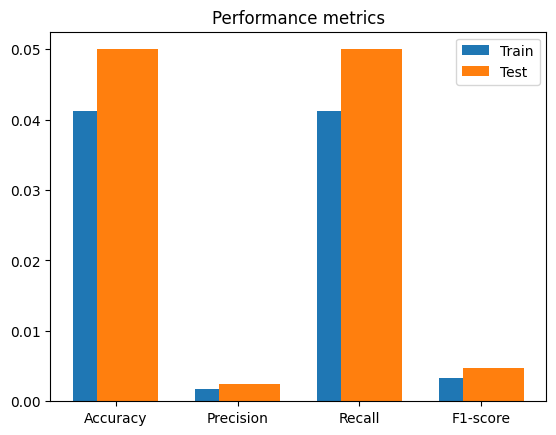

In [ ]:
plt.bar(np.arange(4)-.1,train_metrics,.5)
plt.bar(np.arange(4)+.1,test_metrics,.5)
# plt.bar(np.arange(4),train_metrics,.5)
# plt.bar(np.arange(4),test_metrics,.5)
plt.xticks([0,1,2,3],['Accuracy','Precision','Recall','F1-score'])
# plt.ylim([.9,1])
plt.legend(['Train','Test'])
plt.title('Performance metrics')
plt.show();

In [ ]:
y = test_loader.dataset.tensors[1]
yHat = yHat_test.detach().numpy()

In [ ]:
yHat = yHat.flatten()

In [ ]:
import numpy as np
np.vstack((y.numpy(),yHat,np.abs(y.numpy()-yHat))).T

array([[-1.00000000e+00, -1.14117050e+00,  1.41170502e-01],
       [-1.50000000e+01, -1.51145601e+01,  1.14560127e-01],
       [-1.00000000e+00, -1.06098747e+00,  6.09874725e-02],
       [ 0.00000000e+00, -9.32826996e-02,  9.32826996e-02],
       [ 2.00000000e+00,  2.02922630e+00,  2.92263031e-02],
       [-1.00000000e+01, -1.00764713e+01,  7.64713287e-02],
       [-2.00000000e+00, -1.94851112e+00,  5.14888763e-02],
       [ 1.30000000e+01,  1.30080948e+01,  8.09478760e-03],
       [ 7.00000000e+00,  6.94793892e+00,  5.20610809e-02],
       [-1.60000000e+01, -1.61206741e+01,  1.20674133e-01],
       [ 1.70000000e+01,  1.70125542e+01,  1.25541687e-02],
       [-2.00000000e+00, -1.94851112e+00,  5.14888763e-02],
       [-7.00000000e+00, -7.06314659e+00,  6.31465912e-02],
       [-7.00000000e+00, -7.06565285e+00,  6.56528473e-02],
       [-2.00000000e+00, -2.06878662e+00,  6.87866211e-02],
       [ 2.00000000e+00,  2.01586151e+00,  1.58615112e-02],
       [-1.60000000e+01, -1.61106472e+01